Realice las siguientes tareas de procesamiento de datos:
Join de datasets con información de los post de trabajos, habilidades necesarias e información referente a la compañia que publica el trabajo.
Convertir tipo de datos para asegurar consistencia en los datos.
Realizar algún tipo de tratamiento con los valores nulos.
Validar que los datos estén dentro de los parámetros esperados (ej: revisar valores negativos en columnas que solo acepta números positivos incluyendo el 0).
Realizar alguna manipulación de string y/o fecha.
Filtrar, agrupar y agregar la información para realizar algún análisis que le parezca de interés.
Revisión de valores duplicados.
El resultado del procesamiento de datos debe ser exportado al formato que encuentre mas conveniente.
Se evaluará que el código pueda ser ejecutado completamente en un ambiente con pyspark instalado. Que el código no se pueda ejecutar implicará nota mínima.

José Araya joseignacioaraya15@gmail.com

In [97]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField,StringType,DateType,IntegerType,FloatType,BooleanType, StructType
from pyspark.sql.functions import col,avg, countDistinct, percentile_approx, when, substring, round
import missingno as msno

In [98]:
spark = (
        SparkSession.builder
        .appName("hands-on-pyspark")
        .config("spark.executor.memory","6g")
        .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR") #ALL, OFF, ERROR, DEBUG, INFO, WARN
spark.active()

In [99]:
path_companies = 'C:\Cursos\DataEngineer_Diplomado_Usach\Modulo 6_Sistemas de computación distribuida\Tarea 1\companies.parquet'
path_company_industries = 'C:\Cursos\DataEngineer_Diplomado_Usach\Modulo 6_Sistemas de computación distribuida\Tarea 1\company_industries.csv'
path_company_specialities = 'C:\Cursos\DataEngineer_Diplomado_Usach\Modulo 6_Sistemas de computación distribuida\Tarea 1\company_specialities.csv'
path_employee_counts = 'C:\Cursos\DataEngineer_Diplomado_Usach\Modulo 6_Sistemas de computación distribuida\Tarea 1\employee_counts.csv'
path_job_postings_descriptions = 'C:\Cursos\DataEngineer_Diplomado_Usach\Modulo 6_Sistemas de computación distribuida\Tarea 1\job_postings_description.parquet'
path_job_postings = 'C:\Cursos\DataEngineer_Diplomado_Usach\Modulo 6_Sistemas de computación distribuida\Tarea 1\job_postings.parquet'
path_job_skills = 'C:\Cursos\DataEngineer_Diplomado_Usach\Modulo 6_Sistemas de computación distribuida\Tarea 1\job_skills.csv'

In [100]:
cols = [
    StructField('job_id', StringType(),False),
    StructField('company_id',StringType(),True),
    StructField('title',StringType(),True),
    StructField('max_salary',IntegerType(),True),
    StructField('med_salary',IntegerType(),True),
    StructField('min_salary',IntegerType(),True),
    StructField('pay_period',StringType(),True),
    StructField('formatted_work_type',StringType(),True),
    StructField('location',StringType(),True),
    StructField('applies',IntegerType(),True),
    StructField('original_listed_time',DateType(),True),
    StructField('remote_allowed',BooleanType(),True),
    StructField('Views',IntegerType(),True),
    StructField('job_posting_url',StringType(),True),
    StructField('application_url',StringType(),True),
    StructField('application_type',StringType(),True),
    StructField('expiry',DateType(),True),
    StructField('closed_time',DateType(),True),
    StructField('formatted_experience_level',StringType(),True),
    StructField('skills_desc',StringType(),True),
    StructField('listed_time',DateType(),True),
    StructField('posting_domain',StringType(),True),
    StructField('sponsored',BooleanType(),True),
    StructField('work_type',StringType(),True),
    StructField('currency',StringType(),True),
    StructField('compensation_type',StringType(),True)
]

Schema = StructType(cols)
df_job_postings = spark.read.parquet(path_job_postings, Schema = Schema)
df_job_postings.printSchema()
df_job_postings.show()


root
 |-- job_id: long (nullable = true)
 |-- company_id: double (nullable = true)
 |-- title: string (nullable = true)
 |-- max_salary: double (nullable = true)
 |-- med_salary: double (nullable = true)
 |-- min_salary: double (nullable = true)
 |-- pay_period: string (nullable = true)
 |-- formatted_work_type: string (nullable = true)
 |-- location: string (nullable = true)
 |-- applies: double (nullable = true)
 |-- original_listed_time: double (nullable = true)
 |-- remote_allowed: double (nullable = true)
 |-- views: double (nullable = true)
 |-- job_posting_url: string (nullable = true)
 |-- application_url: string (nullable = true)
 |-- application_type: string (nullable = true)
 |-- expiry: double (nullable = true)
 |-- closed_time: double (nullable = true)
 |-- formatted_experience_level: string (nullable = true)
 |-- skills_desc: string (nullable = true)
 |-- listed_time: double (nullable = true)
 |-- posting_domain: string (nullable = true)
 |-- sponsored: long (nullable = t

In [101]:
df_job_skills  = spark.read.csv(path_job_skills, header=True, sep =',', inferSchema=True)
df_job_skills  = df_job_skills.withColumn ('job_id',col('job_id').cast(StringType()))
df_job_skills.printSchema()
df_job_skills.show(10)

root
 |-- job_id: string (nullable = true)
 |-- skill_abr: string (nullable = true)

+----------+---------+
|    job_id|skill_abr|
+----------+---------+
|3690843087|     ACCT|
|3690843087|      FIN|
|3691763971|     MGMT|
|3691763971|     MNFC|
|3691775263|     MGMT|
|3691775263|     MNFC|
|3691786992|     HCPR|
|3691789797|     MGMT|
|3691789797|     MNFC|
|3691789919|     HCPR|
+----------+---------+
only showing top 10 rows



In [102]:
df_companies = spark.read.parquet(path_companies, header=True,inferSchema=True)

df_companies = df_companies.withColumn('company_id', col('company_id').cast(StringType()))
df_companies = df_companies.withColumn('company_size', col('company_size').cast(IntegerType()))

df_companies.printSchema()
df_companies.show(10)

root
 |-- company_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- company_size: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- address: string (nullable = true)
 |-- url: string (nullable = true)

+----------+--------------------+--------------------+------------+---------+-------+----------------+--------+--------------------+--------------------+
|company_id|                name|         description|company_size|    state|country|            city|zip_code|             address|                 url|
+----------+--------------------+--------------------+------------+---------+-------+----------------+--------+--------------------+--------------------+
|      1009|                 IBM|At IBM, we do mor...|           7|       NY|     US|Armonk, New York|   10504|International Bus...|https://

In [103]:
#Unimos los df y eliminamos columnas duplicadas

df = df_job_postings.join(df_companies, df_job_postings.company_id==df_companies.company_id , how='left').drop(df_job_postings['company_id'])\
        .join(df_job_skills, df_job_postings.job_id == df_job_skills.job_id, how='left').drop(df_job_skills['job_id'])

df.printSchema()
df.show(10)

root
 |-- job_id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- max_salary: double (nullable = true)
 |-- med_salary: double (nullable = true)
 |-- min_salary: double (nullable = true)
 |-- pay_period: string (nullable = true)
 |-- formatted_work_type: string (nullable = true)
 |-- location: string (nullable = true)
 |-- applies: double (nullable = true)
 |-- original_listed_time: double (nullable = true)
 |-- remote_allowed: double (nullable = true)
 |-- views: double (nullable = true)
 |-- job_posting_url: string (nullable = true)
 |-- application_url: string (nullable = true)
 |-- application_type: string (nullable = true)
 |-- expiry: double (nullable = true)
 |-- closed_time: double (nullable = true)
 |-- formatted_experience_level: string (nullable = true)
 |-- skills_desc: string (nullable = true)
 |-- listed_time: double (nullable = true)
 |-- posting_domain: string (nullable = true)
 |-- sponsored: long (nullable = true)
 |-- work_type: string (nullable = tr

In [104]:
print(df.columns)


['job_id', 'title', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 'formatted_work_type', 'location', 'applies', 'original_listed_time', 'remote_allowed', 'views', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'company_id', 'name', 'description', 'company_size', 'state', 'country', 'city', 'zip_code', 'address', 'url', 'skill_abr']


In [105]:
#Cambiamos dtypes del df

df = df.withColumn('company_id', col('company_id').cast(StringType()))
df = df.withColumn('job_id',col('job_id').cast(StringType()))
df = df.withColumn('max_salary',col('max_salary').cast(IntegerType()))
df = df.withColumn('min_salary',col('min_salary').cast(IntegerType()))
df = df.withColumn('sponsored',col('sponsored').cast(BooleanType()))
df = df.withColumn('applies',col('applies').cast(IntegerType()))
df = df.withColumn('remote_allowed',col('remote_allowed').cast(BooleanType()))
df = df.withColumn('views',col('views').cast(IntegerType()))

#Rembramos columnas

df = df.withColumnRenamed('name','name_companie')
df = df.withColumnRenamed('description','description_companie')

df.show(10)
                   

+---------+--------------------+----------+----------+----------+----------+-------------------+-----------------+-------+--------------------+--------------+-----+--------------------+---------------+------------------+-------+-----------+--------------------------+-----------+-----------+--------------+---------+---------+--------+-----------------+----------+--------------------+--------------------+------------+----------+-------+-------------+--------+------------------+--------------------+---------+
|   job_id|               title|max_salary|med_salary|min_salary|pay_period|formatted_work_type|         location|applies|original_listed_time|remote_allowed|views|     job_posting_url|application_url|  application_type| expiry|closed_time|formatted_experience_level|skills_desc|listed_time|posting_domain|sponsored|work_type|currency|compensation_type|company_id|       name_companie|description_companie|company_size|     state|country|         city|zip_code|           address|        

<Axes: >

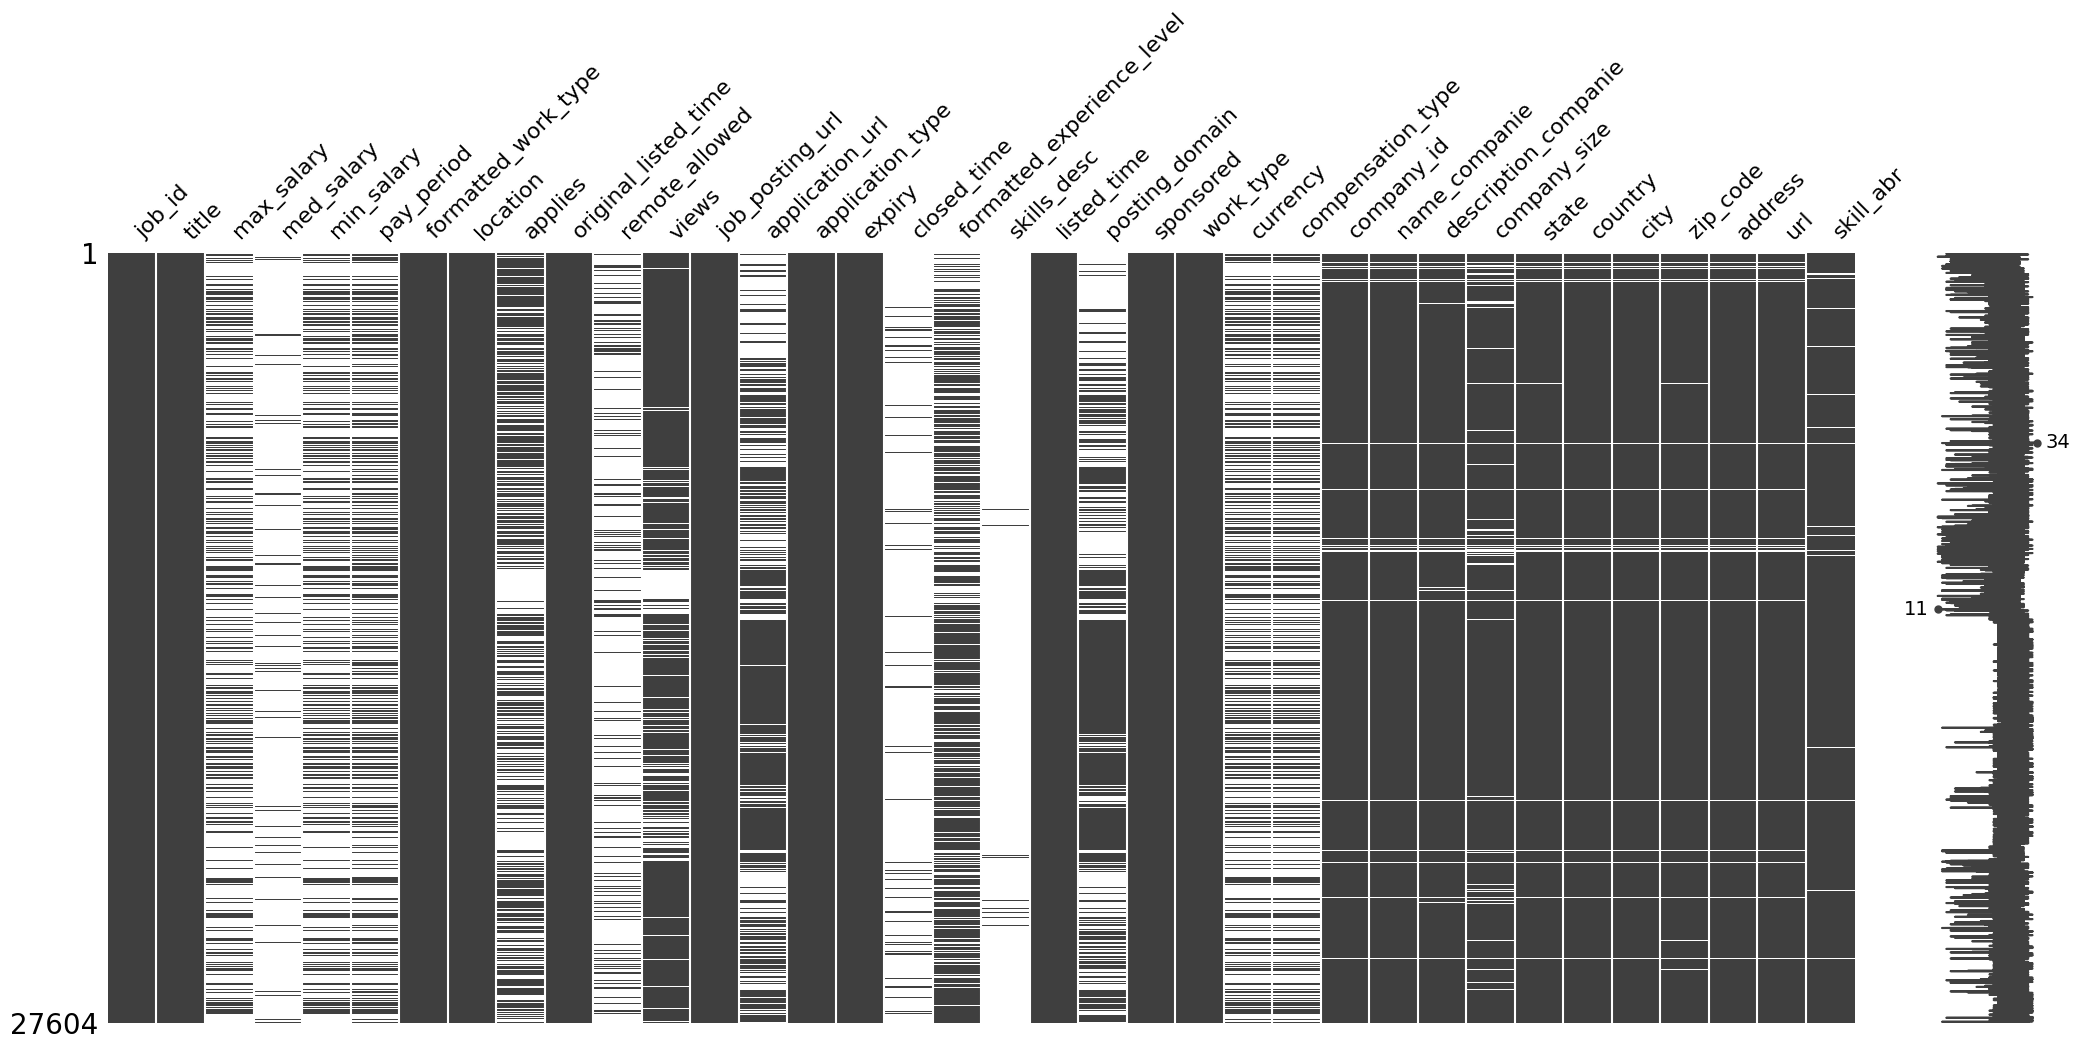

In [106]:
#Revisamos columnas nulas

df_pd = df.toPandas()

%matplotlib inline
msno.matrix(df_pd)

In [107]:
#Dropeamos columnas que están en su mayoría nulas

df = df.drop('med_salary','skills_desc', 'closed_time', 'original_listed_time')

#Dropeamos columnas que no ofrecen enformación valiosa para el análisis
df = df.drop('job_posting_url','original_listed_time','expiry','application_url','listed_time','posting_domain','url','application_type')


In [108]:
#Asignamos valor a nulos en remote_allowed

df = df.fillna({'remote_allowed':0})

In [109]:
df.show(20)

+----------+--------------------+----------+----------+----------+-------------------+-----------------+-------+--------------+-----+--------------------------+---------+---------+--------+-----------------+----------+--------------------+--------------------+------------+----------+-------+-------------+----------+-------------------+---------+
|    job_id|               title|max_salary|min_salary|pay_period|formatted_work_type|         location|applies|remote_allowed|views|formatted_experience_level|sponsored|work_type|currency|compensation_type|company_id|       name_companie|description_companie|company_size|     state|country|         city|  zip_code|            address|skill_abr|
+----------+--------------------+----------+----------+----------+-------------------+-----------------+-------+--------------+-----+--------------------------+---------+---------+--------+-----------------+----------+--------------------+--------------------+------------+----------+-------+------------

In [110]:
df = df.filter ( 'company_id is not null')
df.show()

+----------+--------------------+----------+----------+----------+-------------------+--------------------+-------+--------------+-----+--------------------------+---------+---------+--------+-----------------+----------+-------------+--------------------+------------+-----+-------+----------------+--------+--------------------+---------+
|    job_id|               title|max_salary|min_salary|pay_period|formatted_work_type|            location|applies|remote_allowed|views|formatted_experience_level|sponsored|work_type|currency|compensation_type|company_id|name_companie|description_companie|company_size|state|country|            city|zip_code|             address|skill_abr|
+----------+--------------------+----------+----------+----------+-------------------+--------------------+-------+--------------+-----+--------------------------+---------+---------+--------+-----------------+----------+-------------+--------------------+------------+-----+-------+----------------+--------+---------

In [111]:
valores_unicos = df.select('compensation_type').distinct() 
valores_unicos.show()

# tiene 1 solo valor así que lo dropeamos
df = df.drop('compensation_type')

+-----------------+
|compensation_type|
+-----------------+
|      BASE_SALARY|
|             NULL|
+-----------------+



In [112]:
valores_unicos = df.select('max_salary').distinct() 
valores_unicos.show()

#Reemplazamos por la media registro con valor 31

promedio = df.select(avg('max_salary').alias('promedio')).first()[0]
df = df.withColumn( 'max_salary', when(col('max_salary') == 31, promedio).otherwise(col('max_salary')))


+----------+
|max_salary|
+----------+
|    135000|
|     56680|
|    113000|
|    187027|
|     85100|
|    117500|
|    213000|
|    105252|
|     85000|
|    145200|
|    129089|
|    450000|
|     61330|
|     47900|
|    145000|
|    212000|
|        31|
|    345000|
|     71600|
|    151944|
+----------+
only showing top 20 rows



In [113]:
valores_unicos = df.select('min_salary').distinct() 
valores_unicos.show()

#Reemplazamos por la media registro con valor 31

promedio = df.select(avg('min_salary').alias('promedio')).first()[0]
df = df.withColumn( 'min_salary', when(col('min_salary') == 31, promedio).otherwise(col('min_salary')))

+----------+
|min_salary|
+----------+
|    135000|
|    113000|
|      5518|
|     65478|
|     49331|
|     74166|
|     78400|
|    117500|
|     85000|
|     65300|
|     47900|
|    145200|
|     78700|
|    158300|
|     71580|
|    145000|
|     52100|
|    108500|
|     71600|
|        31|
+----------+
only showing top 20 rows



In [114]:
valores_unicos = df.select('pay_period').distinct() 

valores_unicos = df.select('formatted_work_type').distinct() 

valores_unicos = df.select('location').distinct() 

valores_unicos = df.select('formatted_experience_level').distinct() 

valores_unicos = df.select('work_type').distinct() 

valores_unicos = df.select('currency').distinct()  # dropeamos currency, solo posee usd

df = df.drop('currency')



In [115]:
valores_unicos = df.select('skill_abr').distinct() 

valores_unicos = df.select('name_companie').distinct() 

valores_unicos = df.select('company_size').distinct() 

valores_unicos.show(truncate= False)

+------------+
|company_size|
+------------+
|1           |
|6           |
|3           |
|5           |
|4           |
|7           |
|2           |
|NULL        |
+------------+



<Axes: >

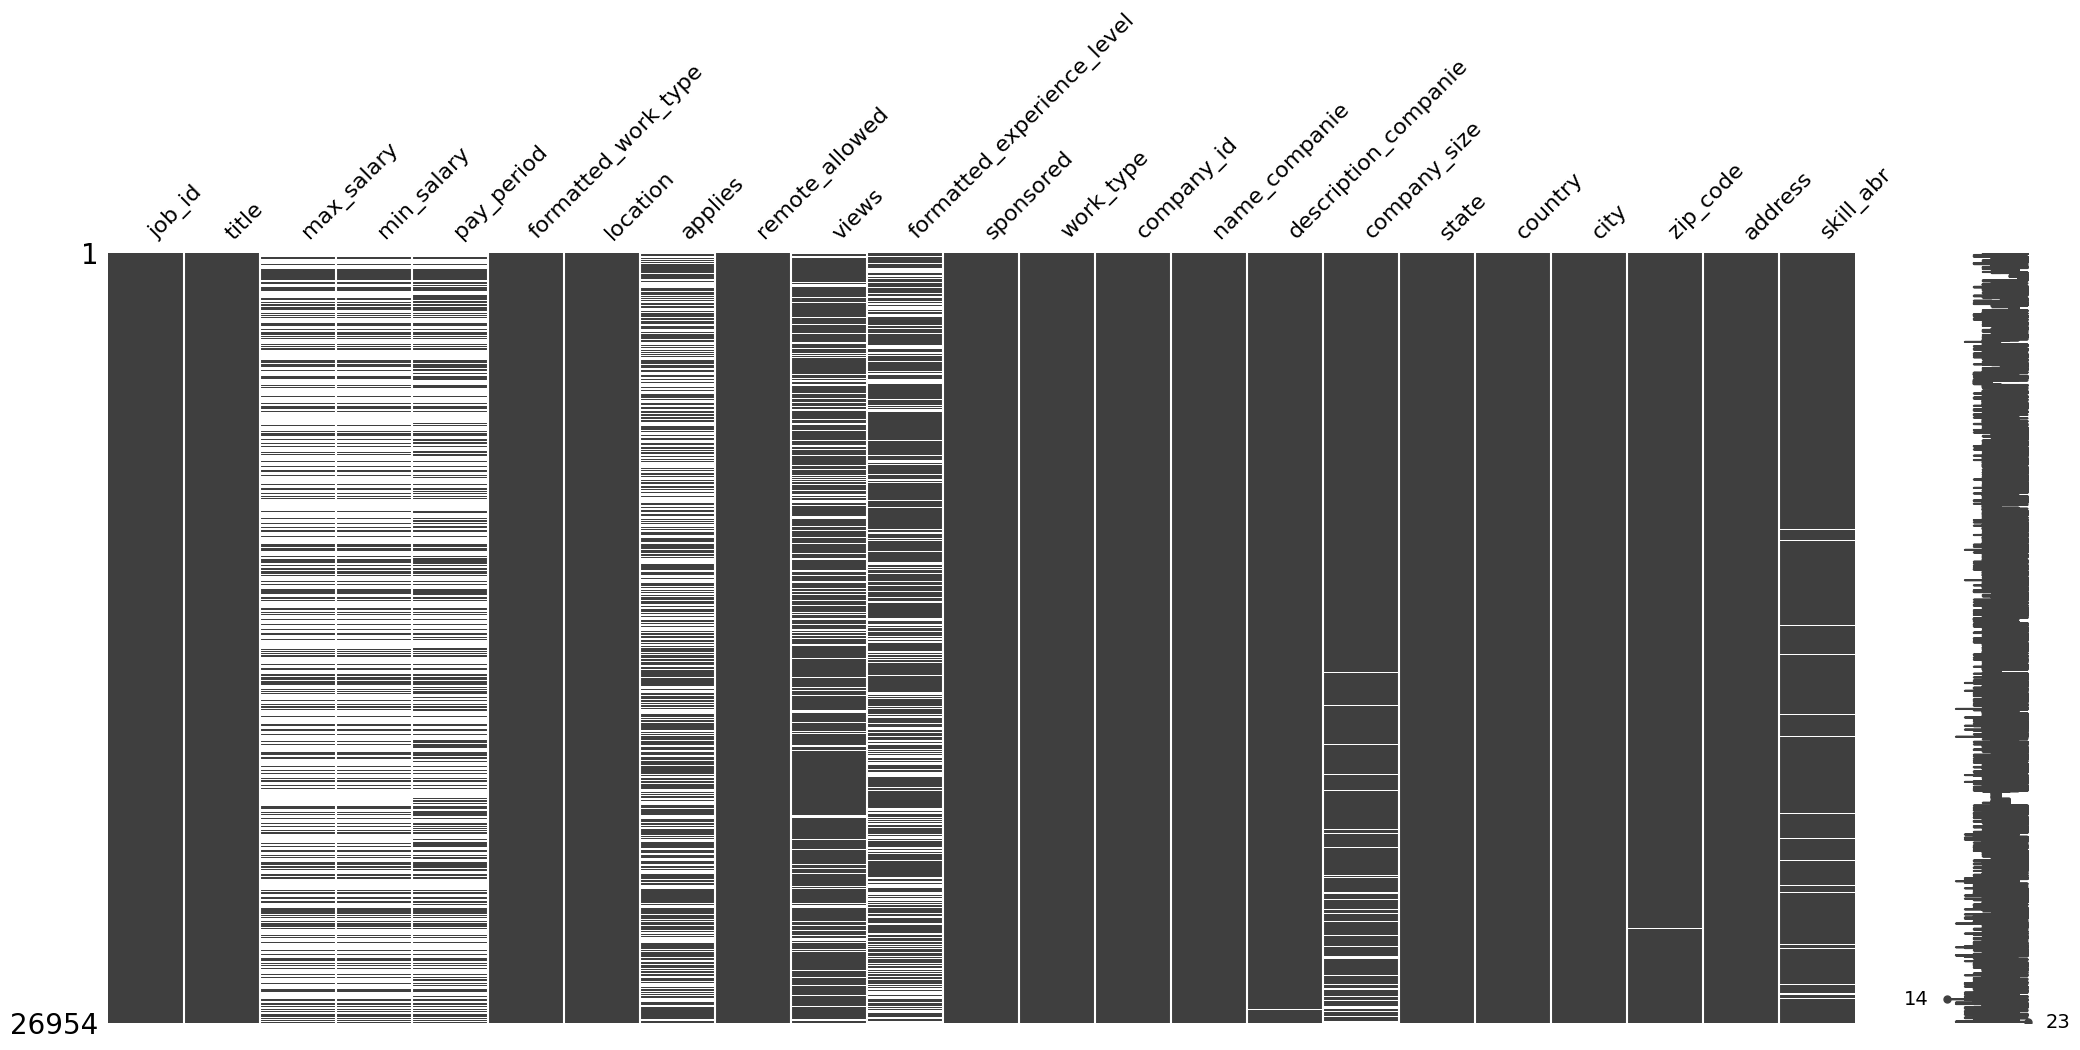

In [116]:
df_pd = df.toPandas()

%matplotlib inline
msno.matrix(df_pd)

In [117]:
#Calculamos promedios para llenar nulos con agregaciones

mediana = df.filter('formatted_experience_level is not null').select(percentile_approx('formatted_experience_level', 0.5).alias('mediana')).first()[0]

df = df.fillna({

            'applies': df.select(avg('applies')).first()[0] ,
            'max_salary': df.select(avg('max_salary')).first()[0],
            'min_salary': df.select(avg('min_salary')).first()[0],
            'views': df.select(avg('views')).first()[0],
            'company_size': df.select(avg('company_size')).first()[0],
            'formatted_experience_level': str(mediana)
            })

In [118]:
#Dropeamos nulos restantes
df = df.dropna(how='any')

In [119]:
#Utilizamos solo la primera letra de pay_period
df = df.withColumn('pay_period', substring(df['pay_period'],1,1))

In [120]:
#Revisamos si hay registros duplicados

filas_original = df.count()

print(filas_original)

filas_sin_duplicados = df.dropDuplicates().count()

print(filas_sin_duplicados)

#No existen registros duplicados a nivel de data frame

11104
11104


In [121]:
#Revisamos si hay empleos duplicados
filas_original = df.select('job_id').count()

print(filas_original)

filas_sin_duplicados = df.select('job_id').dropDuplicates().count()

print(filas_sin_duplicados)

empleos_duplicados = filas_original - filas_sin_duplicados
print (empleos_duplicados)


porcentaje_duplicados = ((empleos_duplicados * 100) / filas_original)
print (f'Está duplicado el  {porcentaje_duplicados:.2f}% de los trabajos')

11104
6195
4909
Está duplicado el  44.21% de los trabajos


In [122]:
df.show(20)

+----------+--------------------+-----------------+-----------------+----------+-------------------+--------------------+-------+--------------+-----+--------------------------+---------+---------+----------+-------------+--------------------+------------+-----+-------+----------------+--------+--------------------+---------+
|    job_id|               title|       max_salary|       min_salary|pay_period|formatted_work_type|            location|applies|remote_allowed|views|formatted_experience_level|sponsored|work_type|company_id|name_companie|description_companie|company_size|state|country|            city|zip_code|             address|skill_abr|
+----------+--------------------+-----------------+-----------------+----------+-------------------+--------------------+-------+--------------+-----+--------------------------+---------+---------+----------+-------------+--------------------+------------+-----+-------+----------------+--------+--------------------+---------+
|3694122103|Appl

In [123]:
#Exportar datos procesados

ruta = r'C:\\Cursos\\DataEngineer_Diplomado_Usach\\Modulo 6_Sistemas de computación distribuida\\Tarea 1\\df.json'

df.write.mode("overwrite").json(ruta)

In [124]:
#Revisamos los salarios promedios por formatted experience level
resultado = df.groupBy("formatted_experience_level").agg(
    round(avg("min_salary"),0).alias("avg_min_salary"),
    round(avg("max_salary"),0).alias("avg_max_salary")
)
resultado.show()

+--------------------------+--------------+--------------+
|formatted_experience_level|avg_min_salary|avg_max_salary|
+--------------------------+--------------+--------------+
|                      None|       64956.0|       96356.0|
|                  Director|      116345.0|      158968.0|
|                 Associate|       47150.0|       61340.0|
|                 Executive|      110548.0|      149501.0|
|               Entry level|       41744.0|       59097.0|
|          Mid-Senior level|       77512.0|      113318.0|
|                Internship|       38934.0|       59608.0|
+--------------------------+--------------+--------------+

